In [2]:
%matplotlib inline 
import pandas as pd 
import numpy as np 
import peak_analist as pk
import copy 
import pylab as pl 
import glob 
import matplotlib.patches as mpatches
from string import Template

In [3]:
rivers = {
    'turkey': {
        'id':'05412500',
        'skew':-0.4,
        'area':4000,
        'name':'Turkey River',
        'years':[80,50,30]
    },
    'cedar': {
        'id':'05464500',
        'skew':-0.4,
        'area':16000,
        'name':'Cedar River',
        'years':[80,50,30]
    },
    'salt': {
        'id':'05452000',
        'skew':-0.3437,
        'area':500,
        'name':'Salt Creek',
        'years':[60,40,30]
    },
    'NorthRacoon': {
        'id':'05482500',
        'skew':-0.3919,
        'area':2500,
        'name':'North Raccoon',
        'years':[70,50,30]
    },
}

## Work to perform:

1. Run each case with 1000 realizations for all the records and for 50 years 
    1.1. For all the records case just run the Error Ind and the Error dep cases. 
    1.2. For the 50 years include the sampling and E+S cases 
2. Figure 3, redo with the 1000 realizations for the 50 years case 
3. Figure 4, redo with first row all the records (only EI and ED) and second row with 50 years including EI+S and S
4. Figure 5, redo
5. Figure 6, All vs all, do it but first row will show for all the records P(RD<10%) and the second row for 50 years P(RD<10%)


To have into account regarding the watflow peak flows 
- code 2 next to the peakflow indicates that it is an estimate (large error)
- code 7 is an historic peak 
- code 6 is a regulation or diversion
- code 1 in line 55 indicates affected by backwater 
- code 2 in line 55 indicates that it is not the maximum of the year 



## Runs names conventions

- EI: Error Inedependent 
- ED: Error Dependent of magnitude 
- S: Sampling (apply only to 50y)
- SEI: Sampling and Error Independent (apply only to 50y)


# Create the time series with $\sigma^2$ dependent on the magnitude 

In [25]:
for river in rivers.keys():
    peaks_file = '{id}f-{name}.txt'.format(**{'id':rivers[river]['id'], 'name':river})
    for year in rivers[river]['years']:
        out_files = '{name}_{years}y_NoiseDep'.format(**{'name':river, 'years': year})        
        a = pk.write_mutated_peaks(peaks_file, out_files+'.txt', out_files+'.psf', out_files+'.prt',
                                  year, 100, rivers[river]['skew'], 0.55, 0.16, method='EMS', 
                                  error = 0.1, add_noise=True)

# Manuscript Figures 

## Figure 3: Contrasting FFE for North Raccoon using the four strategies 

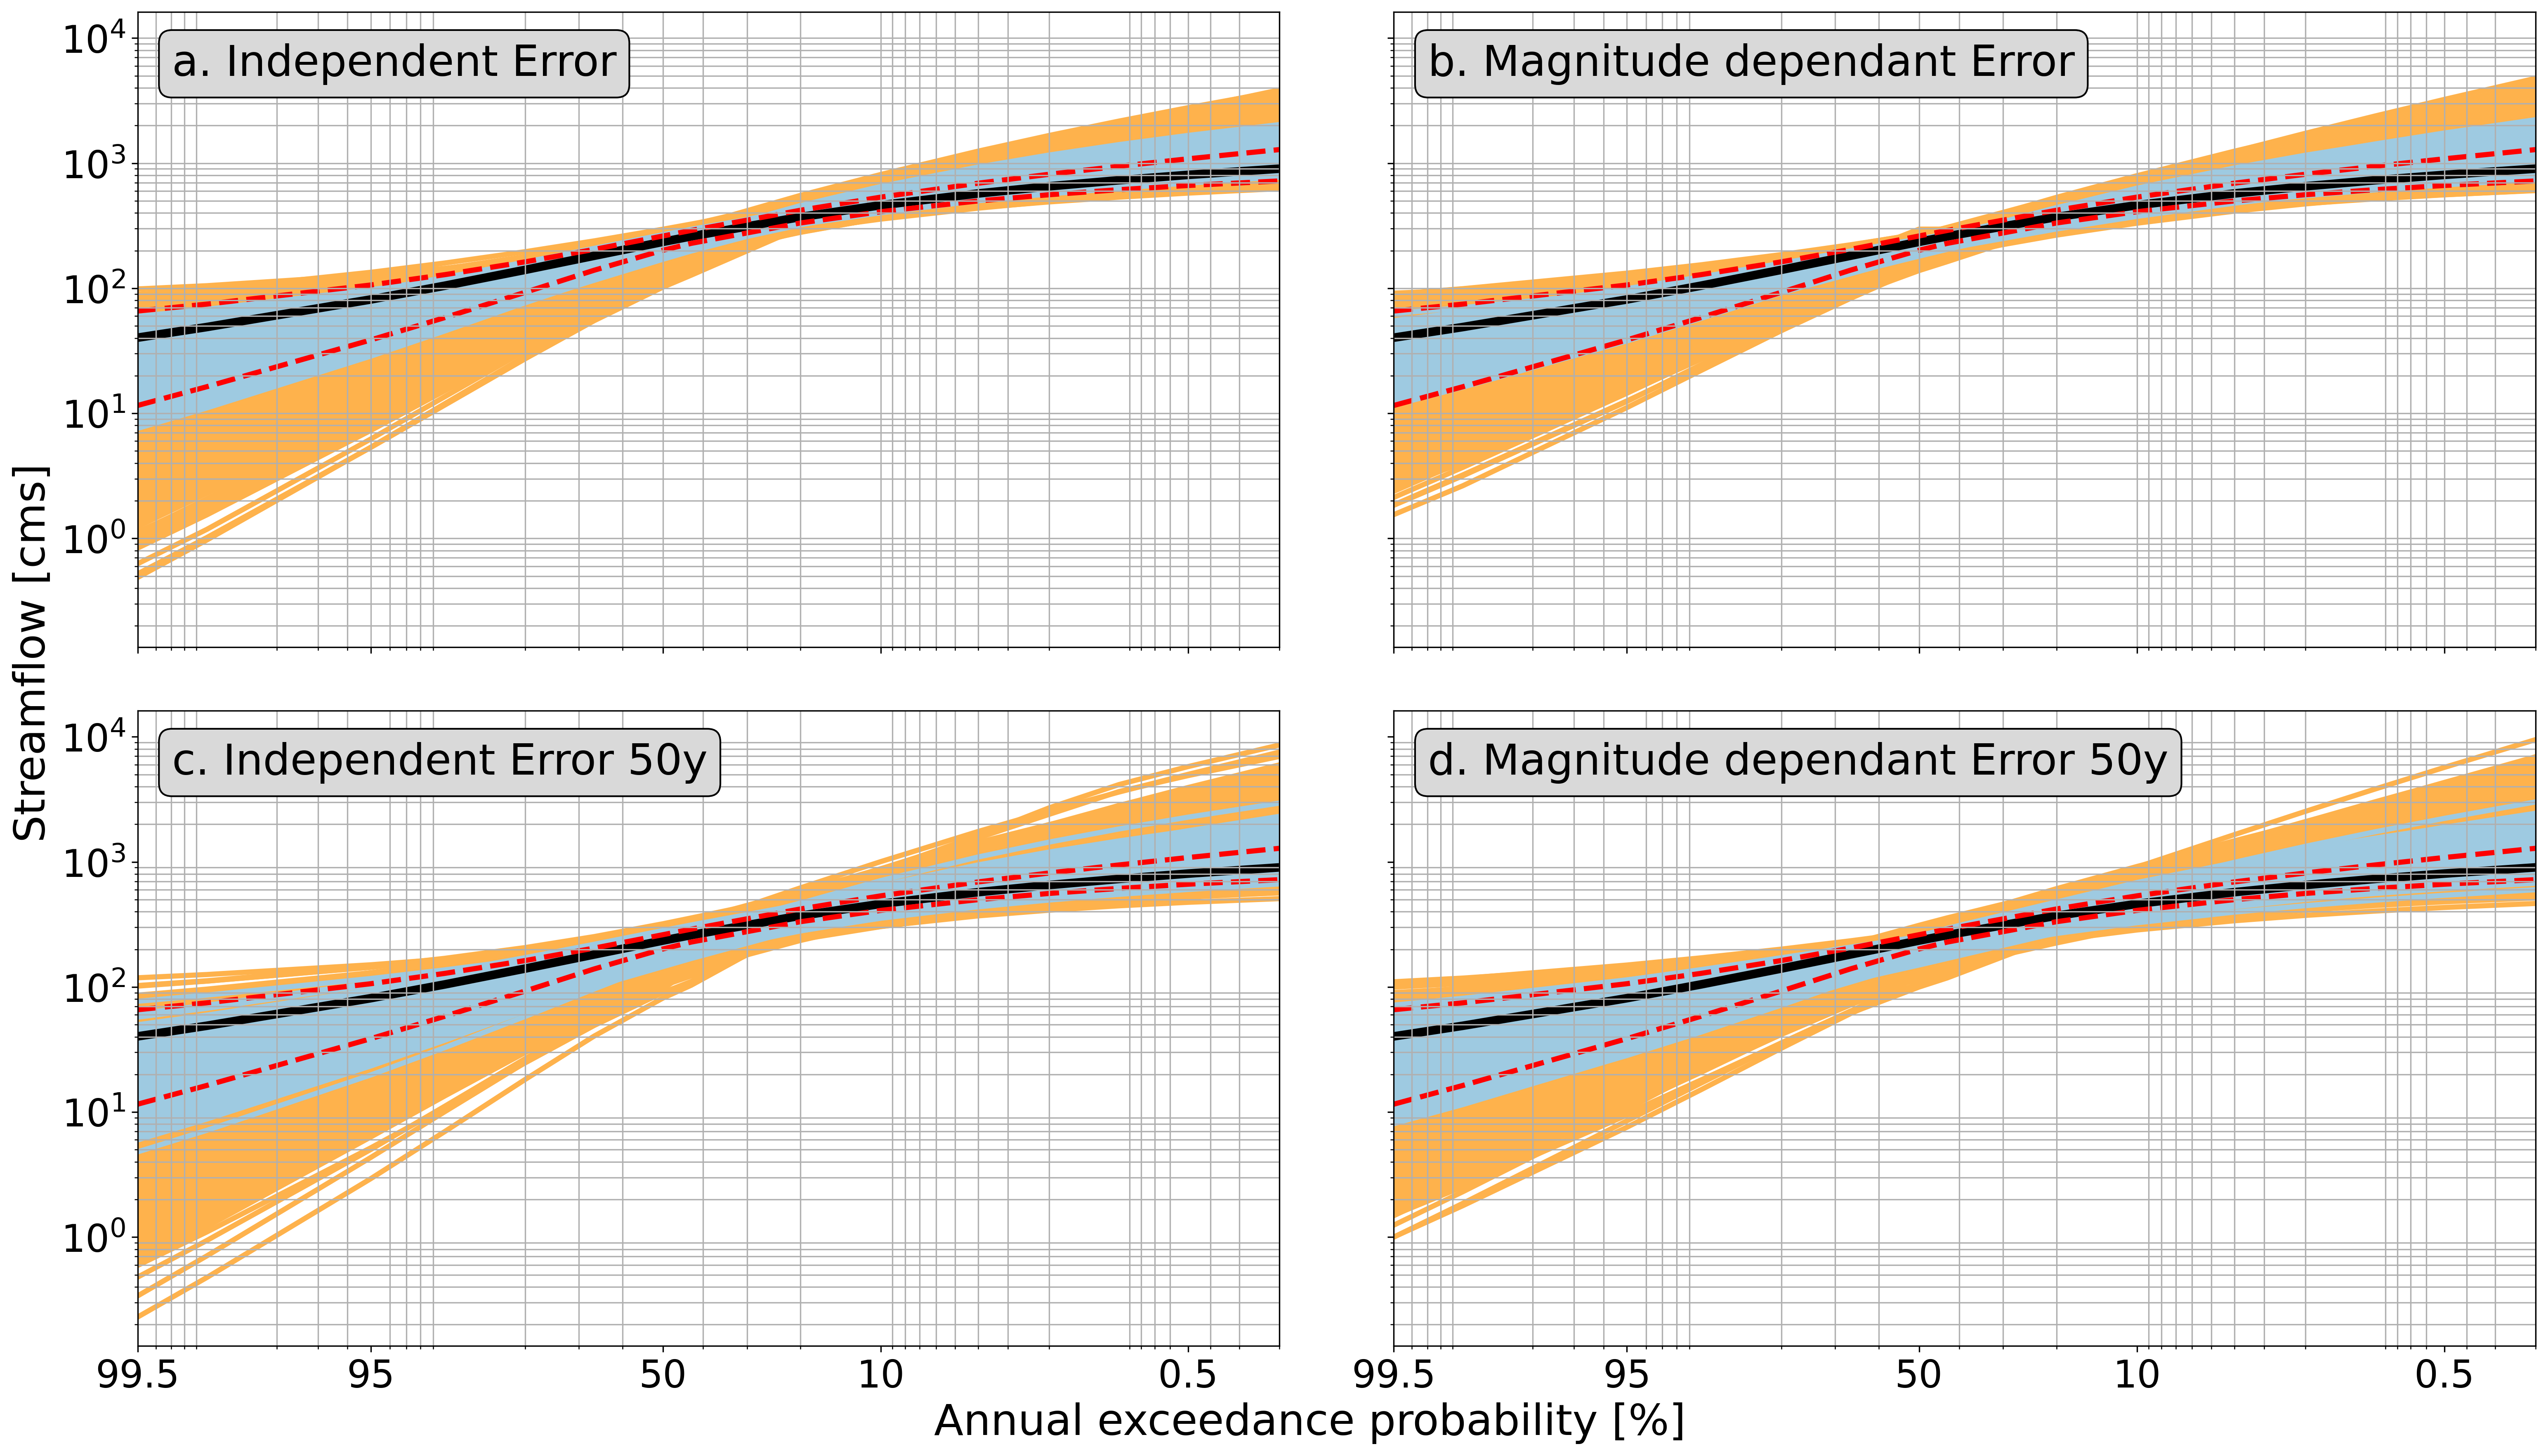

In [5]:
do = pk.read_prt('data/05482500F-NORTHRACOON.PRT')[0]
q,ema,p = pk.read_obs('data/05482500F-NORTHRACOON.PRT')

fig, ax = pl.subplots(2,2,figsize = (25,14), sharey=True, sharex=True, dpi = 300)


dn = pk.read_prt('data/sim/NORTHRACOON_79Y_EI.PRT')
a = pk.plot_freq(do, ax[0][0], dn)
a.legend().set_visible(False)
a.set_xlabel('')
a.set_ylabel('')
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'a. Independent Error', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)

dn = pk.read_prt('data/sim/NORTHRACOON_79Y_ED.PRT')
a = pk.plot_freq(do, ax[0][1], dn)
a.legend().set_visible(False)
a.set_ylabel('')
a.set_xlabel('')
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'b. Magnitude dependant Error', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)

dn = pk.read_prt('data/sim/NORTHRACOON_50Y_EI.PRT')
a = pk.plot_freq(do, ax[1][0], dn)
a.legend().set_visible(False)
a.set_ylabel('                                                       Streamflow [cms]', size = 25)
a.set_xlabel('                                                                                        Annual exceedance probability [%]', size = 25)
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'c. Independent Error 50y', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)
a.grid(which = 'major')

dn = pk.read_prt('data/sim/NORTHRACOON_50Y_ED.PRT')
a = pk.plot_freq(do, ax[1][1], dn)
a.legend().set_visible(False)
a.set_ylabel('')
a.set_xlabel('')
a.set_xticks([0.005,0.05,0.5,0.9,0.995])
a.set_xticklabels([99.5,95,50,10,0.5])
a.text(0.03,0.9,'d. Magnitude dependant Error 50y', transform = a.transAxes, bbox = dict(boxstyle='round', fc = '#d9d9d9'), size = 25)
a.grid(which = 'major')


pl.subplots_adjust(wspace = 0.1, hspace = 0.1)
pl.savefig('figures/Fig3_FFE_Examples.png', bbox_inches = 'tight')

## Figure 4: Relative difference on the means 

In [63]:
for r in rivers.keys():
    #Read the observed FFE
    try:
        do = pk.read_prt('data/{id}F-{name}.PRT'.format(**{'id':rivers[r]['id'], 'name':r.upper()}))[0]
    except:
        do = pk.read_prt('data/{id}F_{name}.PRT'.format(**{'id':rivers[r]['id'], 'name':r.upper()}))[0]
    #Compute the ratios and the relative differences 
    all_ratios,all_mse, stats = pk.ratios4cases_of_gauge('data/sim/{name}_*'.format(**{'name':r.upper()}), do)
    rivers[r].update({'ratios':all_ratios, 'rd':all_mse,'stats':stats})
    for k in all_mse.keys():
        s = str(k)
        np.savez('data/processed/rel_diff_%s_%s.npz' % (r,s),all_mse[50]['wi'])    

In [8]:
r = 'turkey'
try:
    do = pk.read_prt('data/{id}F-{name}.PRT'.format(**{'id':rivers[r]['id'], 'name':r.upper()}))[0]
except:
    do = pk.read_prt('data/{id}F_{name}.PRT'.format(**{'id':rivers[r]['id'], 'name':r.upper()}))[0]
#Compute the ratios and the relative differences 
all_ratios,all_mse, stats = pk.ratios4cases_of_gauge('data/sim/{name}_*'.format(**{'name':r.upper()}), do)
for k in all_mse.keys():
    s = str(k)
    np.savez('data/processed/rel_diff_%s_%s.npz' % (r,s),all_mse[50]['wi'])

In [64]:
def plot_ratios_vs_tr(all_ratios, do, ax,years, path = None, ylim = [0.5,2], 
                      yticks = [0.5,1,1.5,2.0],which='wi',hline=0,ylabel='$MSD(Q_{peak})$', error=0.1, start = 0):
    labels = []
    def add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        labels.append((mpatches.Patch(color=color), label))
        
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l']    
    ratios = all_ratios[years][which]
    vio3 = ax.violinplot(ratios['NOISENOSHUFFLE'][:,[1,6,12,14]], positions=np.arange(0,8,2)+0.2, showmedians=True, widths = 0.3)
    add_label(vio3, 'Error Ind')
    vio2 = ax.violinplot(ratios['NONOISE'][:,[1,6,12,14]], positions=np.arange(0,8,2)-0.2, showmedians=True, widths = 0.3)
    add_label(vio2, 'Bootstrap')
    vio1 = ax.violinplot(ratios['NOISE'][:,[1,6,12,14]], positions=np.arange(0,8,2)-0.45, showmedians=True, widths = 0.3)
    add_label(vio1, 'E+B')
    vio4 = ax.violinplot(ratios['NOISEDEP'][:,[1,6,12,14]], positions=np.arange(0,8,2)+0.45, showmedians=True, widths = 0.3)
    add_label(vio4, 'Error Dep')
    ax.legend(*zip(*labels), loc = 0, fontsize = 'xx-large', ncol = 4,
             bbox_to_anchor=(2.2, -0.14))
    
    
    #ax.hlines(hline, -1,8, color = 'k', ls = '--')
    ax.set_xticks(np.arange(0,8,2))
    ax.set_ylim(ylim[0], ylim[1])
    ax.tick_params(labelsize = 16)
    ax.set_yticks(yticks)
    ax.hlines(error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax.hlines(-error,-1,8,color = 'k',ls = '-',lw = 0.1)
    ax.fill_between([-1,8],[-error,-error],[error,error], color = 'b',alpha = 0.05)
    ax.grid()
    ax.set_xlim(-0.8,7)
    t = '%d years' % (years)
    ax.text(0.05,0.9,t, fontdict = {'size': 16}, transform = ax.transAxes,
            bbox=dict(facecolor='#d9d9d9', alpha=0.9, lw = 2))
    if path is not None:
        pl.savefig(path, bbox_inches = 'tight')
    return ax

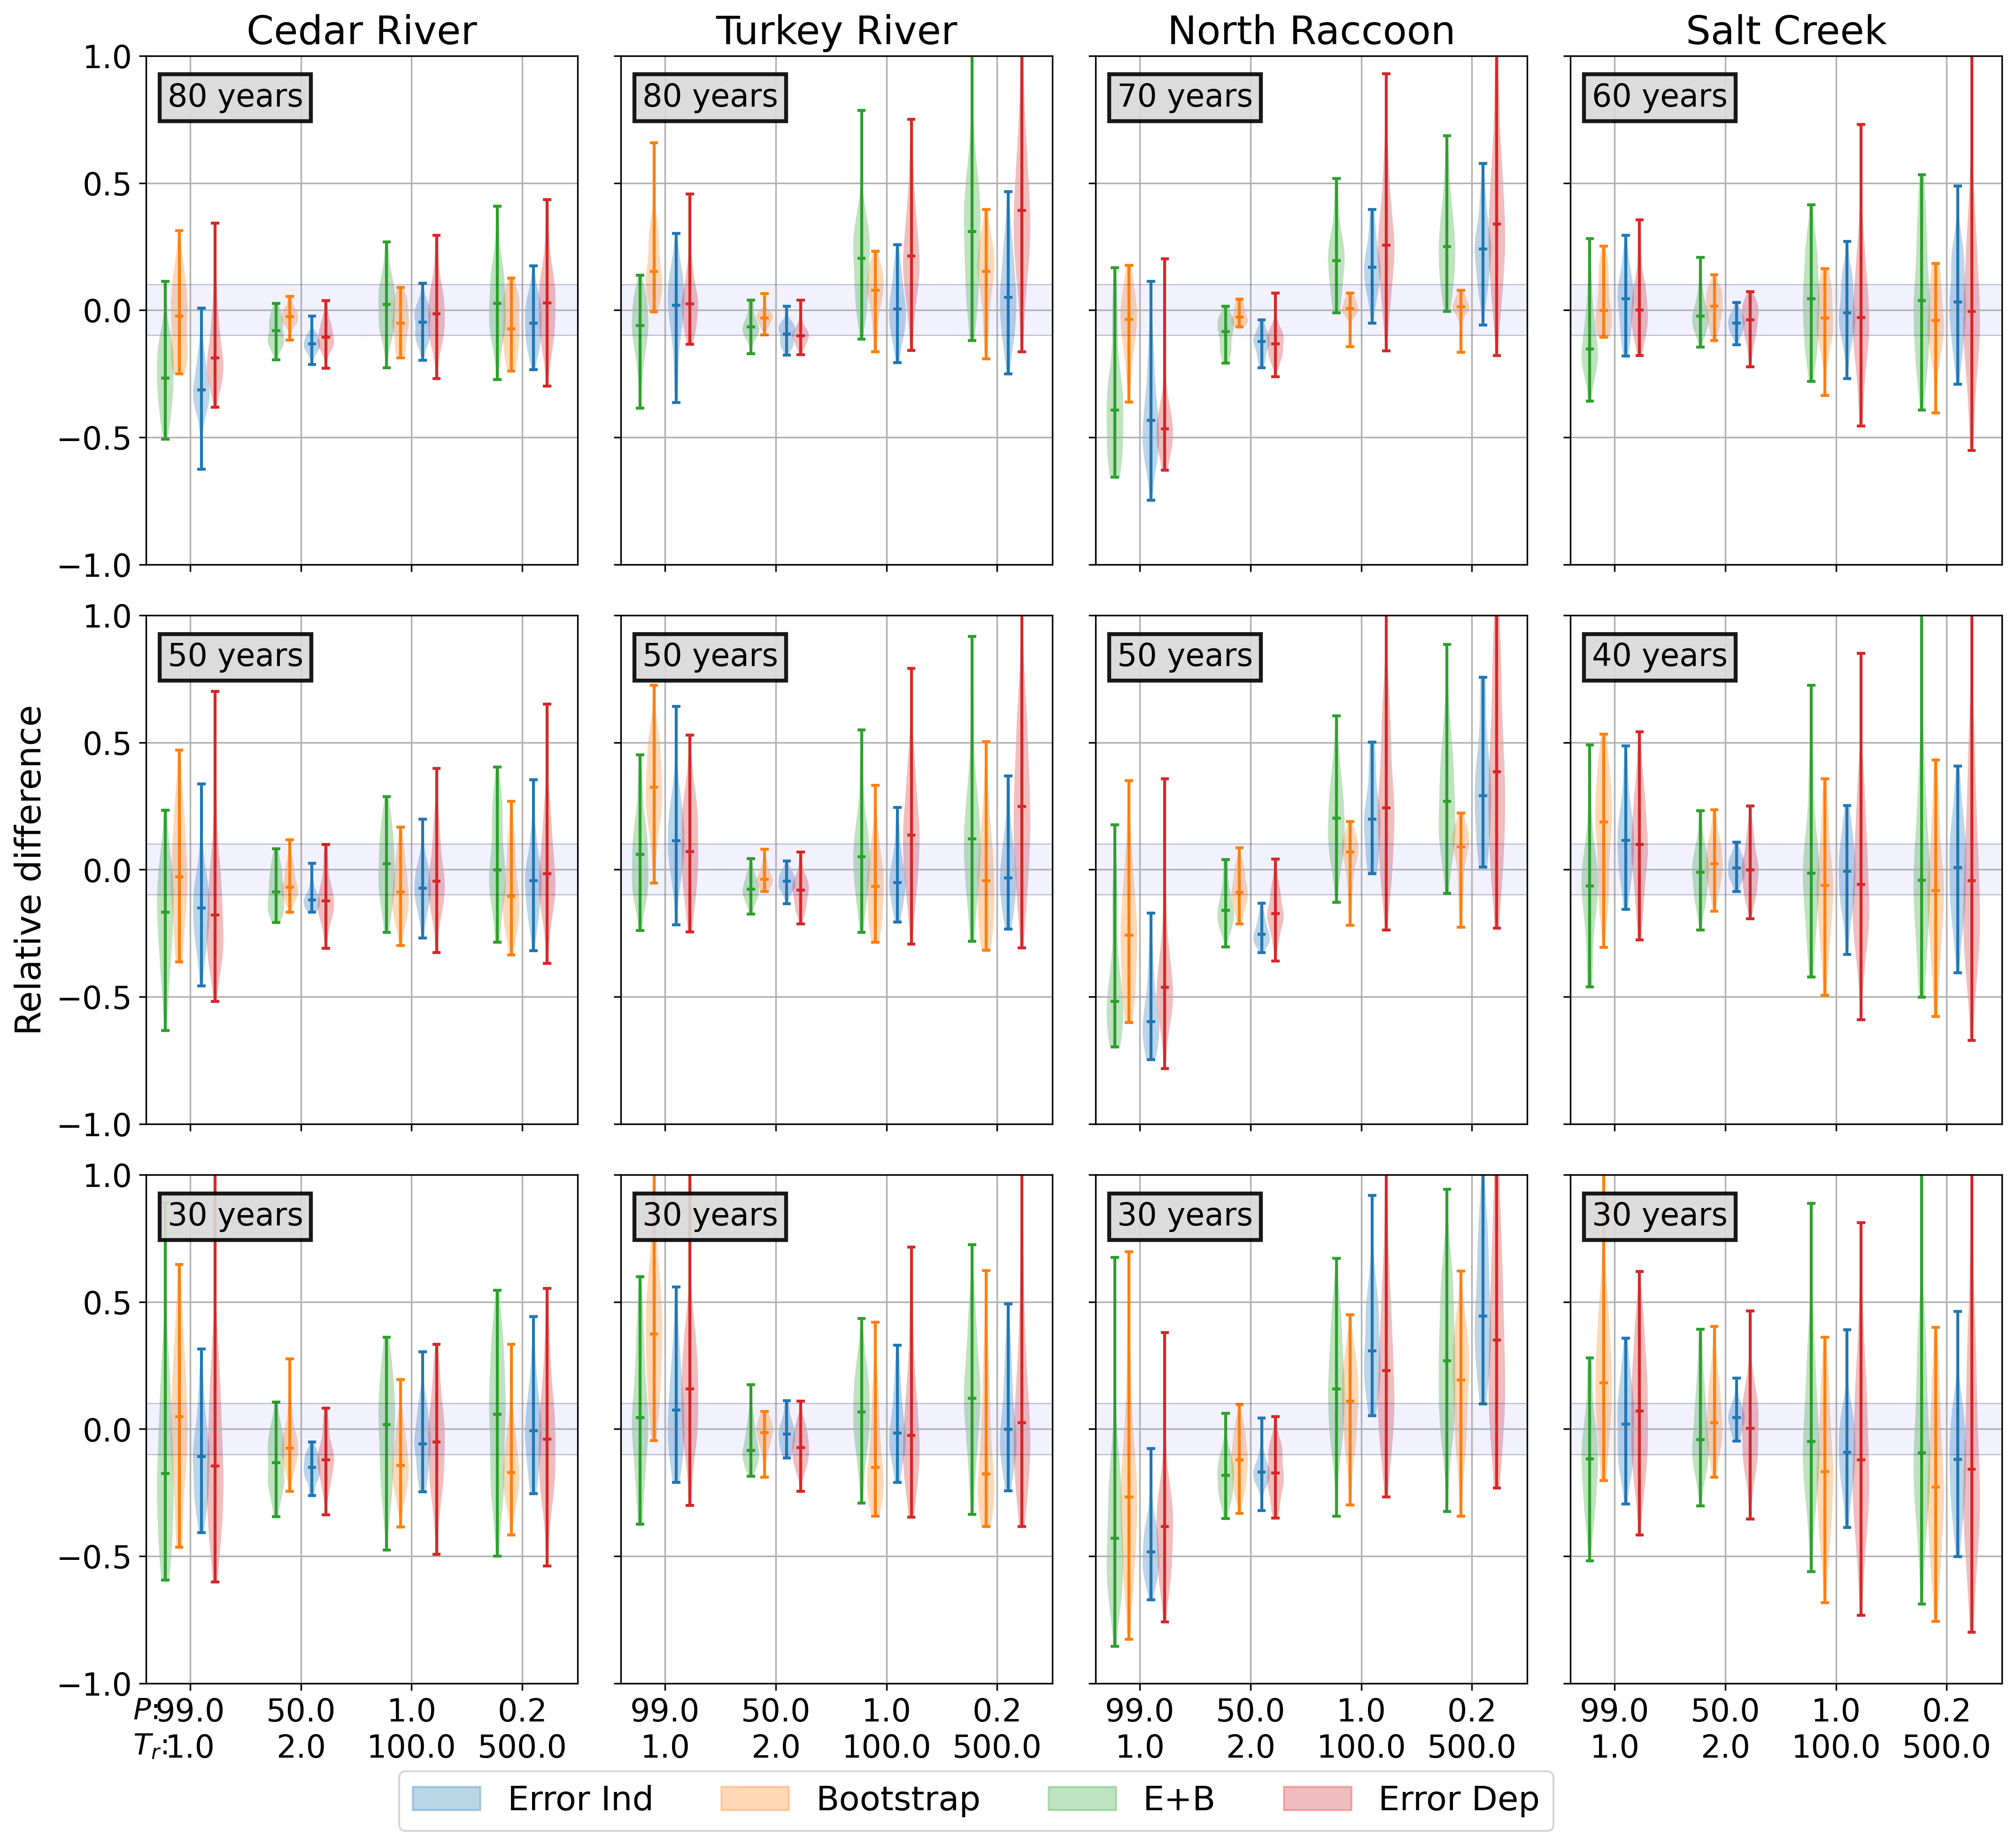

In [82]:
text = []
for p in [99.0,50,1,0.2]:
    pro = p
    Tr=1/(p/100)
    text.append('%.1f\n%.1f' % (pro, Tr))

fig, ax = pl.subplots(3,4, figsize = (17,15), sharey=True, sharex=True, dpi = 300 )
for c1, river in enumerate(['cedar','turkey','NorthRacoon','salt']):
    for c2,year in enumerate(rivers[river]['years']):
        a = plot_ratios_vs_tr(rivers[river]['rd'], do,ax[c2,c1], years=year)
        a.set_ylim(-1,1)
        a.set_yticks([-1,-0.5,0,0.5,1])
        
        if c2 == 2:        
            a.set_xticklabels(text)
            if c1 == 0:
                a.text(-0.03, -0.07, '$P$:', fontdict={'size':15}, transform = a.transAxes,)
                a.text(-0.03, -0.14, '$T_r$:', fontdict={'size':15}, transform = a.transAxes)
        else:
            a.set_xticklabels([])
        if c2 == 1 and c1 == 0:
            a.set_ylabel('Relative difference', size = 18)
        if c2 == 0:
            a.set_title(rivers[river]['name'], size = 20)
        if c2 != 2 or c1 != 1:
            a.get_legend().remove()
        
pl.subplots_adjust(wspace = 0.1, hspace = 0.1)
pl.savefig('figures/Fig4_Relative_differences.png', bbox_inches = 'tight')

## Figure 5: Bands error 

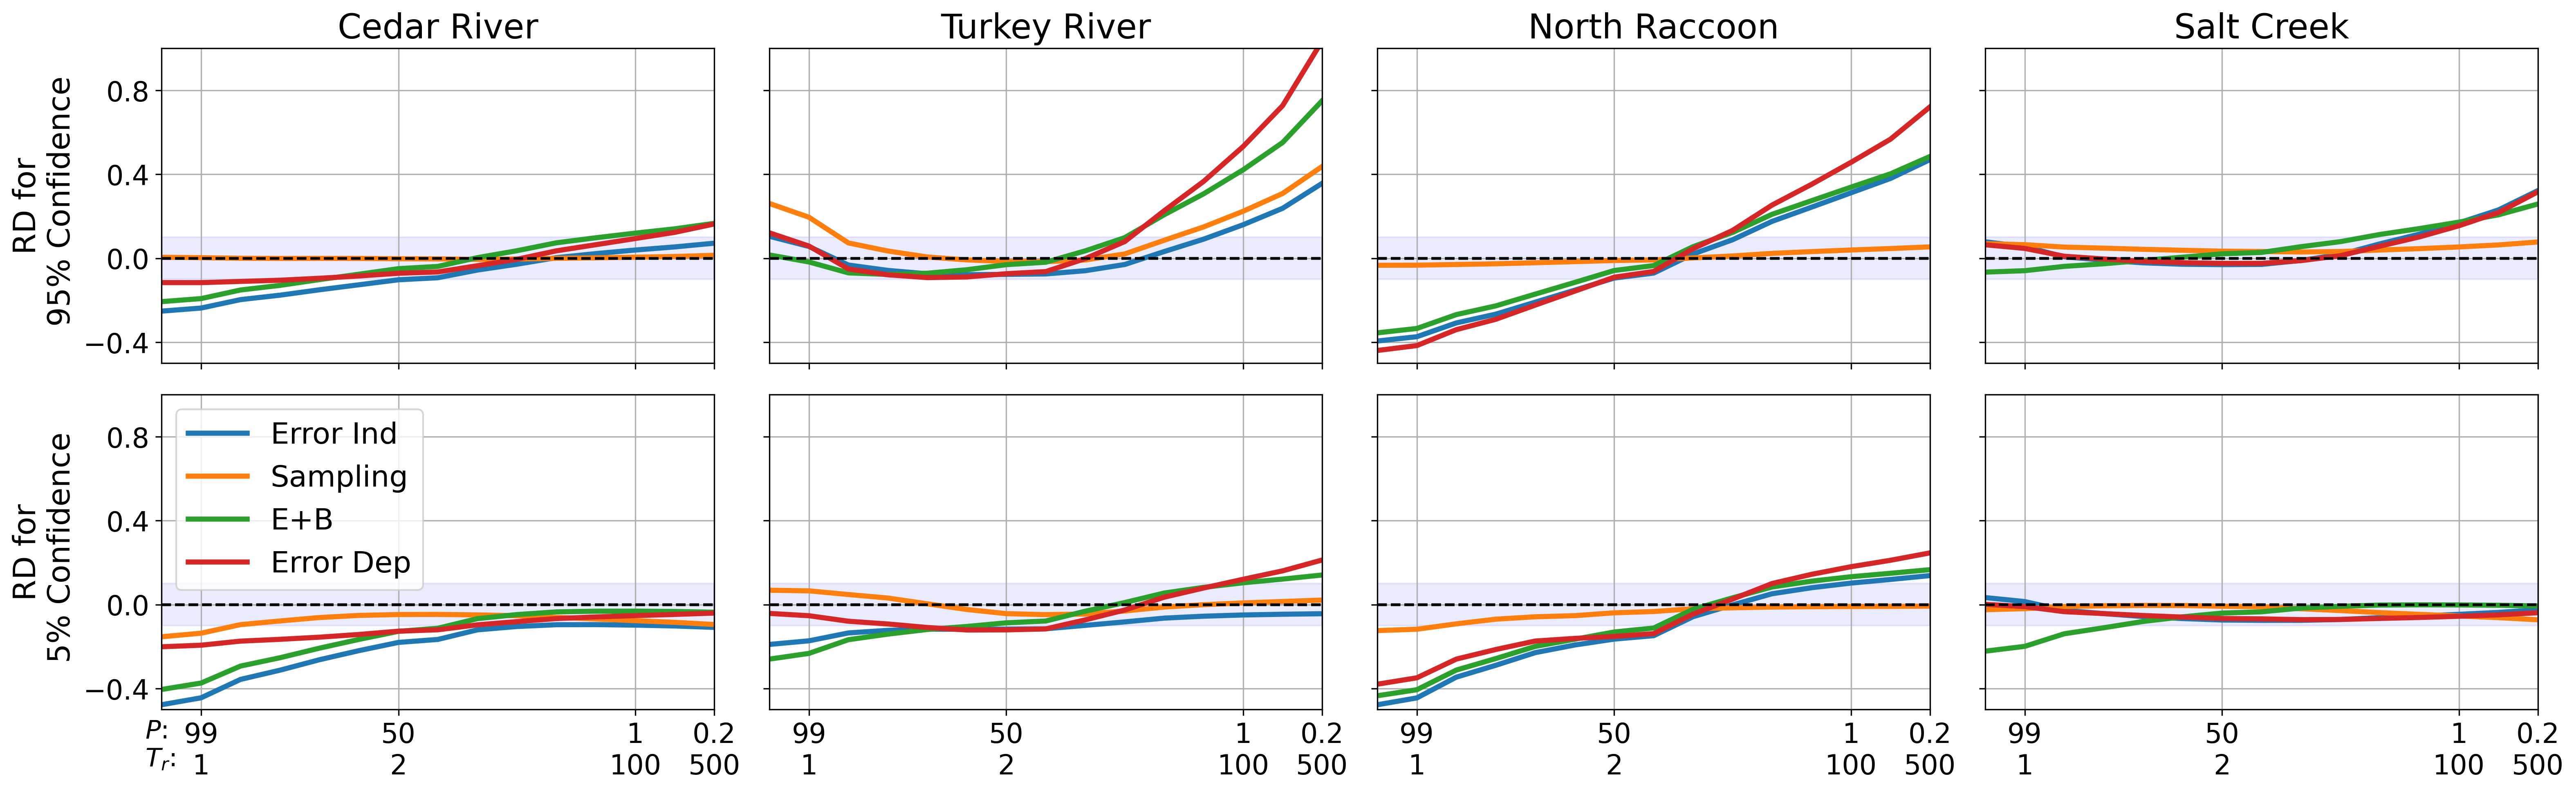

In [133]:
cases = {
    'NOISENOSHUFFLE':'Error Ind',
    'NONOISE':'Sampling',
    'NOISE':'E+B',
    'NOISEDEP':'Error Dep'
}

text = []
for p,t in zip(['99','50','1','0.2'],['1','2','100','500']):
    text.append('%s\n%s' % (p, t))

fig, ax = pl.subplots(2,4,figsize = (25,7), sharex=True, sharey=True, dpi = 300)
error = 0.1
for c1, river in enumerate(['cedar','turkey','NorthRacoon','salt']):
    for c2, band in enumerate([95, 5]):
        a = ax[c2, c1]
        name1 = 'c{band}{year}'.format(**{'band':band,'year':rivers[river]['years'][0]})
        #name2 = 'c{band}{year}'.format(**{'band':band,'year':rivers[river]['years'][-1]})
        for case in cases.keys():
            a.fill_between([-1,14],[-error,-error],[error,error], color = 'b',alpha = 0.02)
            line, = a.plot(rivers[river]['rd'][name1][case].mean(axis = 0), label = cases[case], lw = 3)
            color = line.get_color()
            #a.plot(rivers[river]['rd'][name2][case].mean(axis = 0), label = cases[case], color = color, ls = '--')
            a.set_ylim(-0.5,1)
            a.tick_params(labelsize = 16)
            a.set_yticks([-0.4,0,0.4,0.8])
            a.hlines(0,0,14, color = 'k', ls = '--')
            a.set_xlim(0,14)
            a.grid(True)
            a.set_xticks([1,6,12,14])
            
        if c2 == 0:
            a.set_title(rivers[river]['name'], size = 20)
        if c1 == 0:
            a.set_ylabel('RD for\n {band}% Confidence'.format(**{'band':band}), size = 18)
        if c2 == 1:        
            a.set_xticklabels(text)
            if c1 == 0:
                a.text(-0.03, -0.09, '$P$:', fontdict={'size':15}, transform = a.transAxes,)
                a.text(-0.03, -0.18, '$T_r$:', fontdict={'size':15}, transform = a.transAxes)
                a.legend(loc = 2, fontsize = 'xx-large')
pl.subplots_adjust(wspace = 0.1, hspace = 0.1)
pl.savefig('figures/Fig5_confidence_intervals_error.png', bbox_inches = 'tight')

In [166]:
np.savez('data/processed/turkey_rd.npz',ED102=all_mse[102]['wi']['ED'], ED50=all_mse[50]['wi']['ED'])

In [167]:
d = np.load('data/processed/turkey_rd.npz')

array([[ 0.24375593,  0.17133792,  0.02763443, ...,  0.16765807,
         0.23497487,  0.33110428],
       [-0.10970598, -0.11078794, -0.1093724 , ...,  0.00396563,
         0.01708543,  0.03361648],
       [ 0.0028454 , -0.03199365, -0.09955052, ...,  0.11940956,
         0.17326633,  0.24778601],
       ...,
       [-0.05216567, -0.0740349 , -0.11103712, ...,  0.28023794,
         0.35175879,  0.44966564],
       [ 0.08567815,  0.02829191, -0.07541202, ...,  0.6294338 ,
         0.8040201 ,  1.06036508],
       [ 0.06038571,  0.02221047, -0.04910937, ...,  0.32099581,
         0.40321608,  0.51798301]])